# An Introduction to JAX

#### Prepared for the CBC QuantEcon Workshop (September 2022)

#### John Stachurski

[JAX](https://github.com/google/jax) is scientific library within the Python ecosystem that provides data types, functions and a compiler for fast linear algebra operations and automatic differentiation.

Loosely speaking, JAX is like NumPy with the addition of

* automatic differentiation
* automated GPU/TPU support
* a just-in-time compiler

JAX is often used for machine learning and AI, since it can scale to big data operations on GPUs and automatically differentiate loss functions for gradient decent.

However, JAX is sufficiently low-level that it can be used for many purposes.

Here is a short history of JAX:

* 2015: Google open-sources part of its AI infrastructure called TensorFlow.
* 2016: The popularity of TensorFlow grows rapidly.
* 2017: Facebook open-sources PyTorch beta, an alternative AI framework (developer-friendly, more Pythonic)
* 2018: Facebook launches a full production-ready version of PyTorch.
* 2019: PyTorch surges in popularity (adopted by Uber, Airbnb, Tesla, etc.)
* 2020: Google launches JAX as an open-source framework.
* 2021: Google starts to shift away from TPUs to Nvidia GPUs, extends JAX capabilities.
* 2022: Uptake of Google JAX accelerates rapidly

## Installation

JAX can be installed with or without GPU support.

* Follow [the install guide](https://github.com/google/jax)

Note that JAX is pre-installed with GPU support on [Google Colab](https://colab.research.google.com/).

(Colab Pro offers better GPUs.)

## JAX as a NumPy Replacement

One way to use JAX is as a plug-in NumPy replacement.  Let's look at the similarities and differences.

### Similarities

The following import is standard, replacing `import numpy as np`:

In [1]:
import jax
import jax.numpy as jnp

Now we can use `jnp` in place of `np` for the usual array operations:

In [2]:
a = jnp.asarray((1.0, 3.2, -1.5))

In [3]:
print(a)

[ 1.   3.2 -1.5]


In [4]:
print(jnp.sum(a))

2.6999998


In [5]:
print(jnp.mean(a))

0.9


In [6]:
print(jnp.dot(a, a))

13.490001


However, the array object `a` is not a NumPy array:

In [7]:
a

DeviceArray([ 1. ,  3.2, -1.5], dtype=float32)

In [8]:
type(a)

jaxlib.xla_extension.DeviceArray

Even scalar-valued maps on arrays are of type `DeviceArray`:

In [9]:
jnp.sum(a)

DeviceArray(2.6999998, dtype=float32)

The term `Device` refers to the hardware accelerator (GPU or TPU), although JAX falls back to the CPU if no accelerator is detected.

(In the terminology of GPUs, the "host" is the machine that launches GPU operations, while the "device" is the GPU itself.)


Operations on higher dimensional arrays is also similar to NumPy:

In [16]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float64)

In [17]:
from jax.numpy import linalg

In [18]:
linalg.solve(B, A)

DeviceArray([[1., 1.],
             [1., 1.]], dtype=float64)

In [19]:
linalg.eigh(B)  # Computes eigenvalues and eigenvectors

(DeviceArray([1., 1.], dtype=float64),
 DeviceArray([[1., 0.],
              [0., 1.]], dtype=float64))

### Differences

One difference between NumPy and JAX is that, when running on a GPU, JAX uses 32 bit floats by default.  This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, for some calculations precision matters.  In these cases 64 bit floats can be enforced via the command

In [20]:
jax.config.update("jax_enable_x64", True)

Let's check this works:

In [21]:
jnp.ones(3)

DeviceArray([1., 1., 1.], dtype=float64)

As a NumPy replacement, a more significant difference is that arrays are treated as **immutable**.  For example, with NumPy we can write 

In [22]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [23]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails:

In [24]:
a = jnp.linspace(0, 1, 3)
a

DeviceArray([0. , 0.5, 1. ], dtype=float64)

In [25]:
a[0] = 1

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In line with immutability, JAX does not support inplace operations:

In [26]:
a = np.array((2, 1))
a.sort()
a

array([1, 2])

In [93]:
a = jnp.array((2, 1))
a.sort()
a

DeviceArray([2, 1], dtype=int64)

The designers of JAX chose to make arrays immutable because JAX uses a functional programming style.  More on this below.  

Note that, while mutation is discouraged, it is in fact possible with `at`, as in

In [29]:
a = jnp.linspace(0, 1, 3)
id(a)

139991981772848

In [30]:
a

DeviceArray([0. , 0.5, 1. ], dtype=float64)

In [31]:
a.at[0].set(1)

DeviceArray([1. , 0.5, 1. ], dtype=float64)

We can check that the array is mutated by verifying its identity is unchanged:

In [32]:
id(a)

139991981772848

## Random Numbers



Random numbers are also a bit different in JAX, relative to NumPy.  Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

In [33]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [34]:
key = random.PRNGKey(1)

In [35]:
type(key)

jaxlib.xla_extension.DeviceArray

In [36]:
print(key)

[0 1]


Now we can use the key to generate some random numbers:

In [37]:
x = random.normal(key, (3, 3))
x

DeviceArray([[-1.35247421, -0.2712502 , -0.02920518],
             [ 0.34706456,  0.5464053 , -1.52325812],
             [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [38]:
random.normal(key, (3, 3))

DeviceArray([[-1.35247421, -0.2712502 , -0.02920518],
             [ 0.34706456,  0.5464053 , -1.52325812],
             [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

To produce a (quasi-) independent draw, best practice is to "split" the existing key:

In [39]:
key, subkey = random.split(key)

In [40]:
random.normal(key, (3, 3))

DeviceArray([[ 1.85374374, -0.37683949, -0.61276867],
             [-1.91829718,  0.27219409,  0.54922246],
             [ 0.40451442, -0.58726839, -0.63967753]], dtype=float64)

In [41]:
random.normal(subkey, (3, 3))

DeviceArray([[-0.4300635 ,  0.22778552,  0.57241269],
             [-0.15969178,  0.46719192,  0.21165091],
             [ 0.84118631,  1.18671326, -0.16607783]], dtype=float64)

The function below produces `k` (quasi-) independent random `n x n` matrices using this procedure.

In [42]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices


In [43]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

[[0.97440813 0.3838544 ]
 [0.9790686  0.99981046]]
[[0.3473302  0.17157842]
 [0.89346686 0.01403153]]


One point to remember is that JAX expects tuples to describe array shapes, even for flat arrays.  Hence, to get a one-dimensional array of normal random draws we use `(len, )` for the shape, as in

In [44]:
random.normal(key, (5, ))

DeviceArray([-0.64377279,  0.76961857, -0.29809604,  0.47858776,
             -2.00591299], dtype=float64)

## JIT Compilation

The JAX JIT compiler accelerates logic within functions by fusing linear algebra operations into a single, highly optimized kernel that the host can launch on the GPU / TPU (or CPU if no accelerator is detected).

Consider the following pure Python function.

In [45]:
def f(x, p=1000):
    return sum((k*x for k in range(p)))

Let's build an array to call the function on.

In [46]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [47]:
%time f(x).block_until_ready()

CPU times: user 894 ms, sys: 244 ms, total: 1.14 s
Wall time: 3.29 s


DeviceArray([499500., 499500., 499500., ..., 499500., 499500., 499500.],            dtype=float64)

This code is not particularly fast.  While it is run on the GPU, since `x` is a DeviceArray, each vector `k * x` has to be instantiated before the final sum is computed.

If we JIT-compile the function with JAX, then the operations are fused and no intermediate arrays are created.

In [48]:
f_jit = jax.jit(f)   # target for JIT compilation

Let's run once to compile it:

In [49]:
f_jit(x)

DeviceArray([499500., 499500., 499500., ..., 499500., 499500., 499500.],            dtype=float64)

And now let's time it.

In [50]:
%time f_jit(x).block_until_ready()

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 471 ms


DeviceArray([499500., 499500., 499500., ..., 499500., 499500., 499500.],            dtype=float64)

## Functional Programming

From JAX's documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure:
    
* no dependence on global variables
* no side effects

"A pure function will always return the same result if invoked with the same inputs."

JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here's an illustration of this fact, using global variables:

In [51]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [52]:
x = jnp.ones(2)

In [53]:
f(x)

DeviceArray([2., 2.], dtype=float64)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected --- as long as the same compiled version is called.

In [54]:
a = 42

In [55]:
f(x)

DeviceArray([2., 2.], dtype=float64)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of `a` takes effect:

In [56]:
x = np.ones(3)

In [57]:
f(x)

DeviceArray([43., 43., 43.], dtype=float64)

Moral of the story: write pure functions when using JAX!

## Gradients

JAX can use automatic differentiation to compute gradients.

This can be extremely useful in optimization, root finding and other applications.

Here's a very simple illustration, involving the function

In [58]:
def f(x):
    return (x**2) / 2

Let's take the derivative:

In [59]:
f_prime = jax.grad(f)

In [60]:
f_prime(10.0)

DeviceArray(10., dtype=float64, weak_type=True)

Let's plot the function and derivative, noting that $f'(x) = x$.

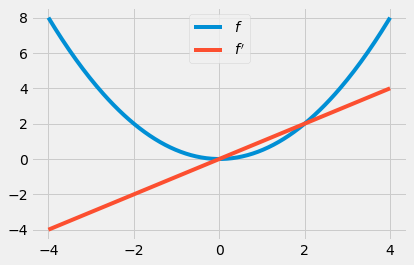

In [61]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()

### Exercise

Recall that Newton's method for solving for the root of $f$ involves iterating on 

$$ q(x) = x - \frac{f(x)}{f'(x)} $$

Write a function called `newton` that takes a function $f$ plus a guess $x_0$ and returns an approximate fixed point.  Your `newton` implementation should use automatic differentiation to calculate $f'$.

Test your `newton` method on the function shown below.

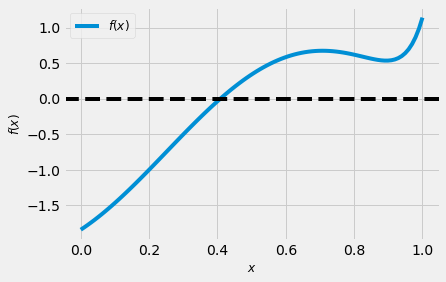

In [88]:
f = lambda x: jnp.sin(4 * (x - 1/4)) + x + x**20 - 1
x = jnp.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, f(x), label='$f(x)$')
ax.axhline(ls='--', c='k')
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$f(x)$', fontsize=12)
ax.legend(fontsize=12)
plt.show()


In [89]:
# Put your code here

In [90]:
for _ in range(14):
    print("solution below")

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


In [91]:
def newton(f, x_0, tol=1e-5):
    f_prime = jax.grad(f)
    def q(x):
        return x - f(x) / f_prime(x)

    error = tol + 1
    x = x_0
    while error > tol:
        y = q(x)
        error = abs(x - y)
        x = y
        
    return x

In [92]:
newton(f, 0.2)

DeviceArray(0.4082935, dtype=float64, weak_type=True)

This number looks good, given the figure.